In [1]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn 

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

from prophet import Prophet

try:
  from google.colab import files
  from google.colab import drive
  uploaded = files.upload()
  !mkdir -p "/content/drive/My Drive/p9"
  drive.mount('/content/drive')
  IN_COLAB = True
except:
  IN_COLAB = False
import warnings
warnings.filterwarnings('once')

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Initialize time series

In [3]:
# Consumption data
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv' if not IN_COLAB else 'ConsumptionIndustry.csv', sep=';')

df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

In [4]:
# El-spot prices
df2 = pd.read_csv('../Dataset/ELSpotPrices.csv' if not IN_COLAB else 'ELSpotPrices.csv', sep=';')
df2['HourDK'] = pd.to_datetime(df2['HourDK'])
df2['SpotPriceDKK'] = df2['SpotPriceDKK'].str.replace(",", ".").astype(float)
df2.index = df2['HourDK']
df2 = df2.iloc[1:] # remove first row, since the measurement at that time is not present in other dataset
df2.drop(columns=['HourUTC', 'HourDK', 'PriceArea', 'SpotPriceEUR'], inplace=True)

Functions

In [5]:
def plot_data(data_train, data_test, predictions, save_at=''):
  plt.figure(figsize=(7, 3))
  plt.plot(data_train.index, data_train, label=f'Train ({data_train.index[0]} - {data_train.index[-1]})')
  plt.plot(data_test.index, data_test, label=f'Test ({data_test.index[0]} - {data_test.index[-1]})')
  plt.plot(data_test.index, predictions, label='Prediction')
  plt.title('Consumption in danish private households with prediction')
  plt.xlabel('Measurements')
  plt.ylabel('Power (kW / charger)')
  plt.legend()
  if save_at:
    plt.savefig(save_at)
  plt.show()

def sample_data_with_train_window(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test=None):
  model_res = model.fit()

  if "SARIMA" in model_name and "STL" not in model_name:
    return model_res.get_forecast(steps=forecast_horizon, exog=exog_data_test).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)

def create_result_table(results, columns=[]):
  result_table = pd.DataFrame(results)
  result_table.columns = columns
  result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)
  return result_table


Optimize functions

In [6]:
def optimize_SARIMA(data_train, data_test, forecast_horizon, model_name):
  results = []
  best_rmse = 0
  p = d = q = range(0, 3)
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
      try:
          model = SARIMAX(data_train, order=param, seasonal_order=seasonal_param)
          predictions = forecast_whitebox_model(model, forecast_horizon, model_name)
      except:
          continue
      
      rmse = root_mean_squared_error(data_test, predictions)
      results.append([f"{param}x{seasonal_param}", rmse])
      print(f"{param}x{seasonal_param} - RMSE: {rmse}")

      if rmse < best_rmse or best_rmse == 0:
        best_prediction = predictions

  result_table = create_result_table(results, columns=['params', 'rmse'])
  return result_table, best_prediction

def optimize_SARIMAX(data_train, data_test, forecast_horizon, model_name, exog_data_train=None, exog_data_test=None):
  results = []
  best_rmse = 0
  p = d = q = range(0, 3)
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
      try:
          model = SARIMAX(data_train, order=param, seasonal_order=seasonal_param, exog=exog_data_train)
          predictions = forecast_whitebox_model(model, forecast_horizon, model_name, exog_data_test=exog_data_test)
      except:
          continue
      
      rmse = root_mean_squared_error(data_test, predictions)
      results.append([f"{param}x{seasonal_param}", rmse])
      print(f"{param}x{seasonal_param} - RMSE: {rmse}")

      if rmse < best_rmse or best_rmse == 0:
        best_prediction = predictions

  result_table = create_result_table(results, columns=['params', 'rmse'])
  return result_table, best_prediction

def optimize_Theta_model(data_train, data_test, forecast_horizon, model_name):
  results = []
  best_rmse = 0
  p = range(1, 25)
  d = [True, False]
  u = [True, False]
  m = ['additive', 'multiplicative']
  di = [True, False]

  for param in itertools.product(p, d, u, m, di):
    try:
      model = ThetaModel(data_train, period=param[0], deseasonalize=param[1], use_test=param[2], method=param[3], difference=param[4])
    except:
      continue

    predictions = forecast_whitebox_model(model, forecast_horizon, model_name)
    rmse = root_mean_squared_error(data_test, predictions)
    results.append([param, rmse])
    print(f"{param} - RMSE: {rmse}")
    
    if rmse < best_rmse or best_rmse == 0:
      best_prediction = predictions

  result_table = create_result_table(results, columns=['params', 'rmse'])
  return result_table, best_prediction

Optimizing through whole dataset

(0, 0, 0)x(0, 0, 0, 12) - RMSE: 14954.979171491483
(0, 0, 0)x(0, 0, 1, 12) - RMSE: 15911.726044643401
(0, 0, 0)x(0, 0, 2, 12) - RMSE: 21404.44661994039
(0, 0, 0)x(0, 1, 0, 12) - RMSE: 9609.448500636767
(0, 0, 0)x(0, 1, 1, 12) - RMSE: 8390.680771575628
(0, 0, 0)x(0, 1, 2, 12) - RMSE: 7319.407408550672
(0, 0, 0)x(0, 2, 0, 12) - RMSE: 12030.852407736142
(0, 0, 0)x(0, 2, 1, 12) - RMSE: 9727.393575680222
(0, 0, 0)x(0, 2, 2, 12) - RMSE: 11572.798064303212
(0, 0, 0)x(1, 0, 0, 12) - RMSE: 17237.474398568764
(0, 0, 0)x(1, 0, 1, 12) - RMSE: 8337.391564228208
(0, 0, 0)x(1, 0, 2, 12) - RMSE: 22841.549886250352
(0, 0, 0)x(1, 1, 0, 12) - RMSE: 2441.307611660827
(0, 0, 0)x(1, 1, 1, 12) - RMSE: 2578.1207275909815
(0, 0, 0)x(1, 1, 2, 12) - RMSE: 2459.0866790224104
(0, 0, 0)x(1, 2, 0, 12) - RMSE: 3881.1439556431637
(0, 0, 0)x(1, 2, 1, 12) - RMSE: 4229.937966144928
(0, 0, 0)x(1, 2, 2, 12) - RMSE: 4133.797579193119
(0, 0, 0)x(2, 0, 0, 12) - RMSE: 3038.896438714697
(0, 0, 0)x(2, 0, 1, 12) - RMSE: 5065.8581

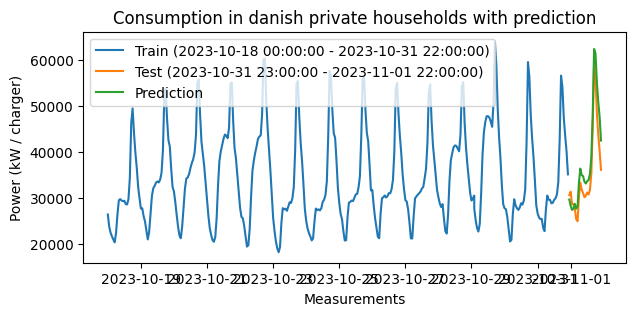

In [7]:
model_name = 'SARIMAX'
date_start = '2023-11-01'
window_train_size = 1440 #hours
forecast_horizon = 336 #hours

data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
exog_data = sample_data_with_train_window(df2, date_start, window_train_size)

data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
exog_data_train, exog_data_test = get_next_window(exog_data, window_train_size, forecast_horizon)

warnings.filterwarnings("ignore")
result, pred = optimize_SARIMAX(data_train, data_test, forecast_horizon, model_name, exog_data_train=exog_data_train, exog_data_test=exog_data_test)
warnings.filterwarnings("default")

if IN_COLAB:
  plot_data(data_train, data_test, pred, save_at=f'{window_train_size}_{forecast_horizon}_{model_name}.png')
  result.to_csv(f'{window_train_size}_{forecast_horizon}_{model_name}.csv')
else:
  plot_data(data_train, data_test, pred, save_at=f'../Results/Whitebox/Tuning/{window_train_size}_{forecast_horizon}_{model_name}.png')
  result.to_csv(f'../Results/Whitebox/Tuning/{window_train_size}_{forecast_horizon}_{model_name}.csv')